In [1]:
# All dependencies

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import requests
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from os import path
from time import time
from mpl_toolkits.mplot3d import Axes3D as plt3

In [2]:
def dataframe_from_csv(file_name, exclude_cols):
    cols = list(pd.read_csv(f"{file_name}.csv", nrows=1))

    return pd.read_csv(f"{file_name}.csv", usecols=[a for a in cols if a not in exclude_cols])

def get_accuracy(y_test, y_pred, use_np_mean=False):
    if use_np_mean:
        accuracy = np.mean(y_test == y_pred)
    else:
        accuracy = np.dot(y_test, y_pred) / (la.norm(y_test) * la.norm(y_pred))
    
    return float(f"{accuracy * 100:.3f}")

In [3]:
# Download data files
urls = {
    "vehicles": "https://www.dropbox.com/scl/fi/rfywugpl0vxo5mc5b7uy7/Vehicles0514.csv?rlkey=v4yygd6hc96ejfm9nt1fvadz9&dl=0",
    "casualties": "https://www.dropbox.com/scl/fi/o1ljw70bzrwmx0x8etifq/Casualties0514.csv?rlkey=iwyg1ergtazhl6mgwqk78xn5s&dl=0",
    "accidents": "https://www.dropbox.com/scl/fi/7enn6tyaavc8ch8hlib0f/Accidents0514.csv?rlkey=u316i9rln87722m1fefzfp5ba&dl=0",
    "data-guide": "https://www.dropbox.com/scl/fi/amogx0ugusmivneq6ardz/Road-Accident-Safety-Data-Guide.xls?rlkey=rnkxrf6eqjer67x2lv99tzvvv&dl=0"
}

data_frames = {}

exclude_columns = ["Accident_Index", "LSOA_of_Accident_Location"]
for file_name in list(urls.keys())[:-1]:
    print(f"Loading {file_name}.csv")
    if path.exists(f"{file_name}.csv"):
        data_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)
        continue
        
    direct_url = urls[file_name].replace("&dl=0", "&dl=1")
    response = requests.get(direct_url)

    with open(f"{file_name}.csv", "wb") as f:
        f.write(response.content)
        print(f"Wrote {file_name}.csv")

    data_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)

print("Done!")

Loading vehicles.csv
Loading casualties.csv
Loading accidents.csv
Done!


In [4]:
def plot_ftrs(X, y, dimensions=2, cmap="viridis"):
    components = PCA(n_components=(dimensions)).fit(X).transform(X)
    if dimensions == 2:
        fig = plt.figure().add_subplot(111)
        scatter = fig.scatter(components[:, 0], components[:, 1], c=y, cmap=cmap)
    else:
        fig = plt.figure().add_subplot(111, projection="3d")
        scatter = fig.scatter(components[:, 0], components[:, 1], components[:, 2], c=y, cmap=cmap)
    
    plt.colorbar(scatter, ax=fig, ticks=list(np.unique(y)))
    plt.show()

def fit_predict(pipe, tt_splits, params={}, timed=True):
    if timed: start_time = time()
    X_train, X_test, y_train, y_test = tt_splits

    for key in params.keys():
        if key == "C":
            for val in params[key]:
                print(f"Fitting {key} = {val}")
                pipe.set_params(svc__C=val)

                pipe.fit(X_train, y_train)
                print(f"Accuracy = {get_accuracy(y_test, accident_pipe.predict(X_test))}%")

            if timed: print(f"\nFitting {num_features} features over {len(params[key])} params took {(time() - start_time) / 60:.3f} minutes")
            return

    print("No custom params, fitting default...")
    pipe.fit(X_train, y_train)
    print(f"Accuracy = {get_accuracy(y_test, accident_pipe.predict(X_test))}%")
    if timed: print(f"\nFitting {num_features} features took {time() - start_time:.3f} seconds")
        

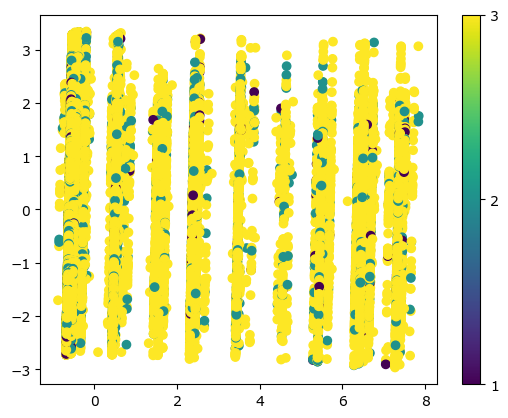

In [5]:
# First Question: How does the weather impact the serverity of the accident?
weather_conditions = ["Longitude", "Latitude", "Weather_Conditions", "Road_Surface_Conditions",
                      "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"]
accident_data = data_frames["accidents"][weather_conditions]
# Remove all nan rows (only for longitude and latitude)
accident_data = accident_data.dropna().values
num_features = int(accident_data.shape[0] * 0.1) + 1
accident_data = accident_data[:num_features]

X = accident_data[:, :-1]
y = accident_data[:, -1]

plot_ftrs(X, y, dimensions=2)

In [7]:
accident_pipe = Pipeline([("scaler", SS()), ("svc", SVC(kernel="linear"))])
fit_predict(accident_pipe, tts(X, y, test_size=0.3), params={"C": [0.0001, 0.001, 0.01, 0.1, 1]})

Fitting C = 0.0001
Accuracy = 99.032%
Fitting C = 0.001
Accuracy = 99.032%
Fitting C = 0.01
Accuracy = 99.032%
Fitting C = 0.1
Accuracy = 99.032%
Fitting C = 1
Accuracy = 99.032%

Fitting 164049 features over 5 params took 509.121 seconds
